In [1]:
# Standard Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
# plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
import seaborn as sns
from IPython.display import Image, display
# other
from scipy.stats import ttest_ind, t, pearsonr

# Path to modules
sys.path.append('../modules')
# Import my modules
from teleconnections import build_teleconnection_df
from timeseries import select_months
from statistical_tests import pearsonr_autocorrelation

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures

# USE pandas.options TO DISPLAY FLOATS TO TWO DECIMAL PLACES
pd.options.display.float_format = "{:,.2f}".format

In [3]:
start_date = '1979-03-01'
end_date = '2018-05-31'

tele = build_teleconnection_df('seasonal', 'ANOM', start_date, end_date)
tele

,ao,pdo,enso,sh
date,,,,
1979-03-01,-0.71,-0.08,0.19,-2.01
1979-06-01,0.08,0.19,0.18,-2.01
1979-09-01,-0.27,0.85,0.54,-2.01
1979-12-01,-0.54,0.23,0.46,0.05
1980-03-01,-0.97,0.68,0.44,0.05
...,...,...,...,...
2017-03-01,0.18,0.37,0.35,-0.55
2017-06-01,0.38,-0.24,-0.14,-0.55
2017-09-01,0.05,-0.49,-0.85,-0.55


In [4]:
df_index_djf = select_months(tele, 12, 2)
df_index_mam = select_months(tele, 3, 5)
print('# DJF years: ', len(df_index_djf))
print('# MAM years: ', len(df_index_mam))

# DJF years:  39
# MAM years:  40


In [5]:
def ar_annual_df(ssn, nk):
    ## Import csv
    fname_id = 'HUV500t0120050cor'
    filepath = path_to_out + fname_id + 'hma_AR-types-' + ssn + '.csv'
    df = pd.read_csv(filepath)

    # set up datetime index
    df = df.rename(columns={'Unnamed: 0': 'date'})
    df = df.set_index(pd.to_datetime(df.date))

    ## Total typecount
    typelist = [1, 2, 3]
    ntypes = len(typelist)
    type_count = df['AR_CAT'].value_counts()
    print(type_count)

    # percentages
    totdays = np.sum(type_count)
    type_freq = type_count / totdays
    print(type_freq*100)
    
    ## Break up columns into different AR Types
    keys = []
    for k in range(nk):
        keys.append("AR_CAT{:1d}".format(k+1,))

    values = np.zeros((len(df.index)))
    dicts = dict(zip(keys, values))

    df_cat = pd.DataFrame(dicts, index=df.index)

    for k in range(nk):
        idx = (df['AR_CAT'] == k+1)
        col = "AR_CAT{:1d}".format(k+1,)
        df_cat.loc[idx, col] = 1
    
    ## resamples data to quarterly
    df_ann = df_cat.resample('QS-DEC').sum()
    freq = df_cat.resample('QS-DEC').count()
    
    # select current season
    if ssn == 'djf':
        idx = (df_ann.index.month == 12)
    elif ssn == 'mam':
        idx = (df_ann.index.month == 3)
    
    df_ann = df_ann.loc[idx]
    # get total of all AR types
    df_ann['AR_ALL'] = df_ann['AR_CAT1'] + df_ann['AR_CAT2'] + df_ann['AR_CAT3']
    
    return df_ann

In [6]:
df_djf = ar_annual_df(ssn='djf', nk=3)
df_mam = ar_annual_df(ssn='mam', nk=3)

0    3149
3     160
2     108
1     103
Name: AR_CAT, dtype: int64
0   89.46
3    4.55
2    3.07
1    2.93
Name: AR_CAT, dtype: float64
0    3239
1     154
2     146
3     141
Name: AR_CAT, dtype: int64
0   88.02
1    4.18
2    3.97
3    3.83
Name: AR_CAT, dtype: float64


/home/nash/DATA/repositories/AR_types/figs/donut_plot.png


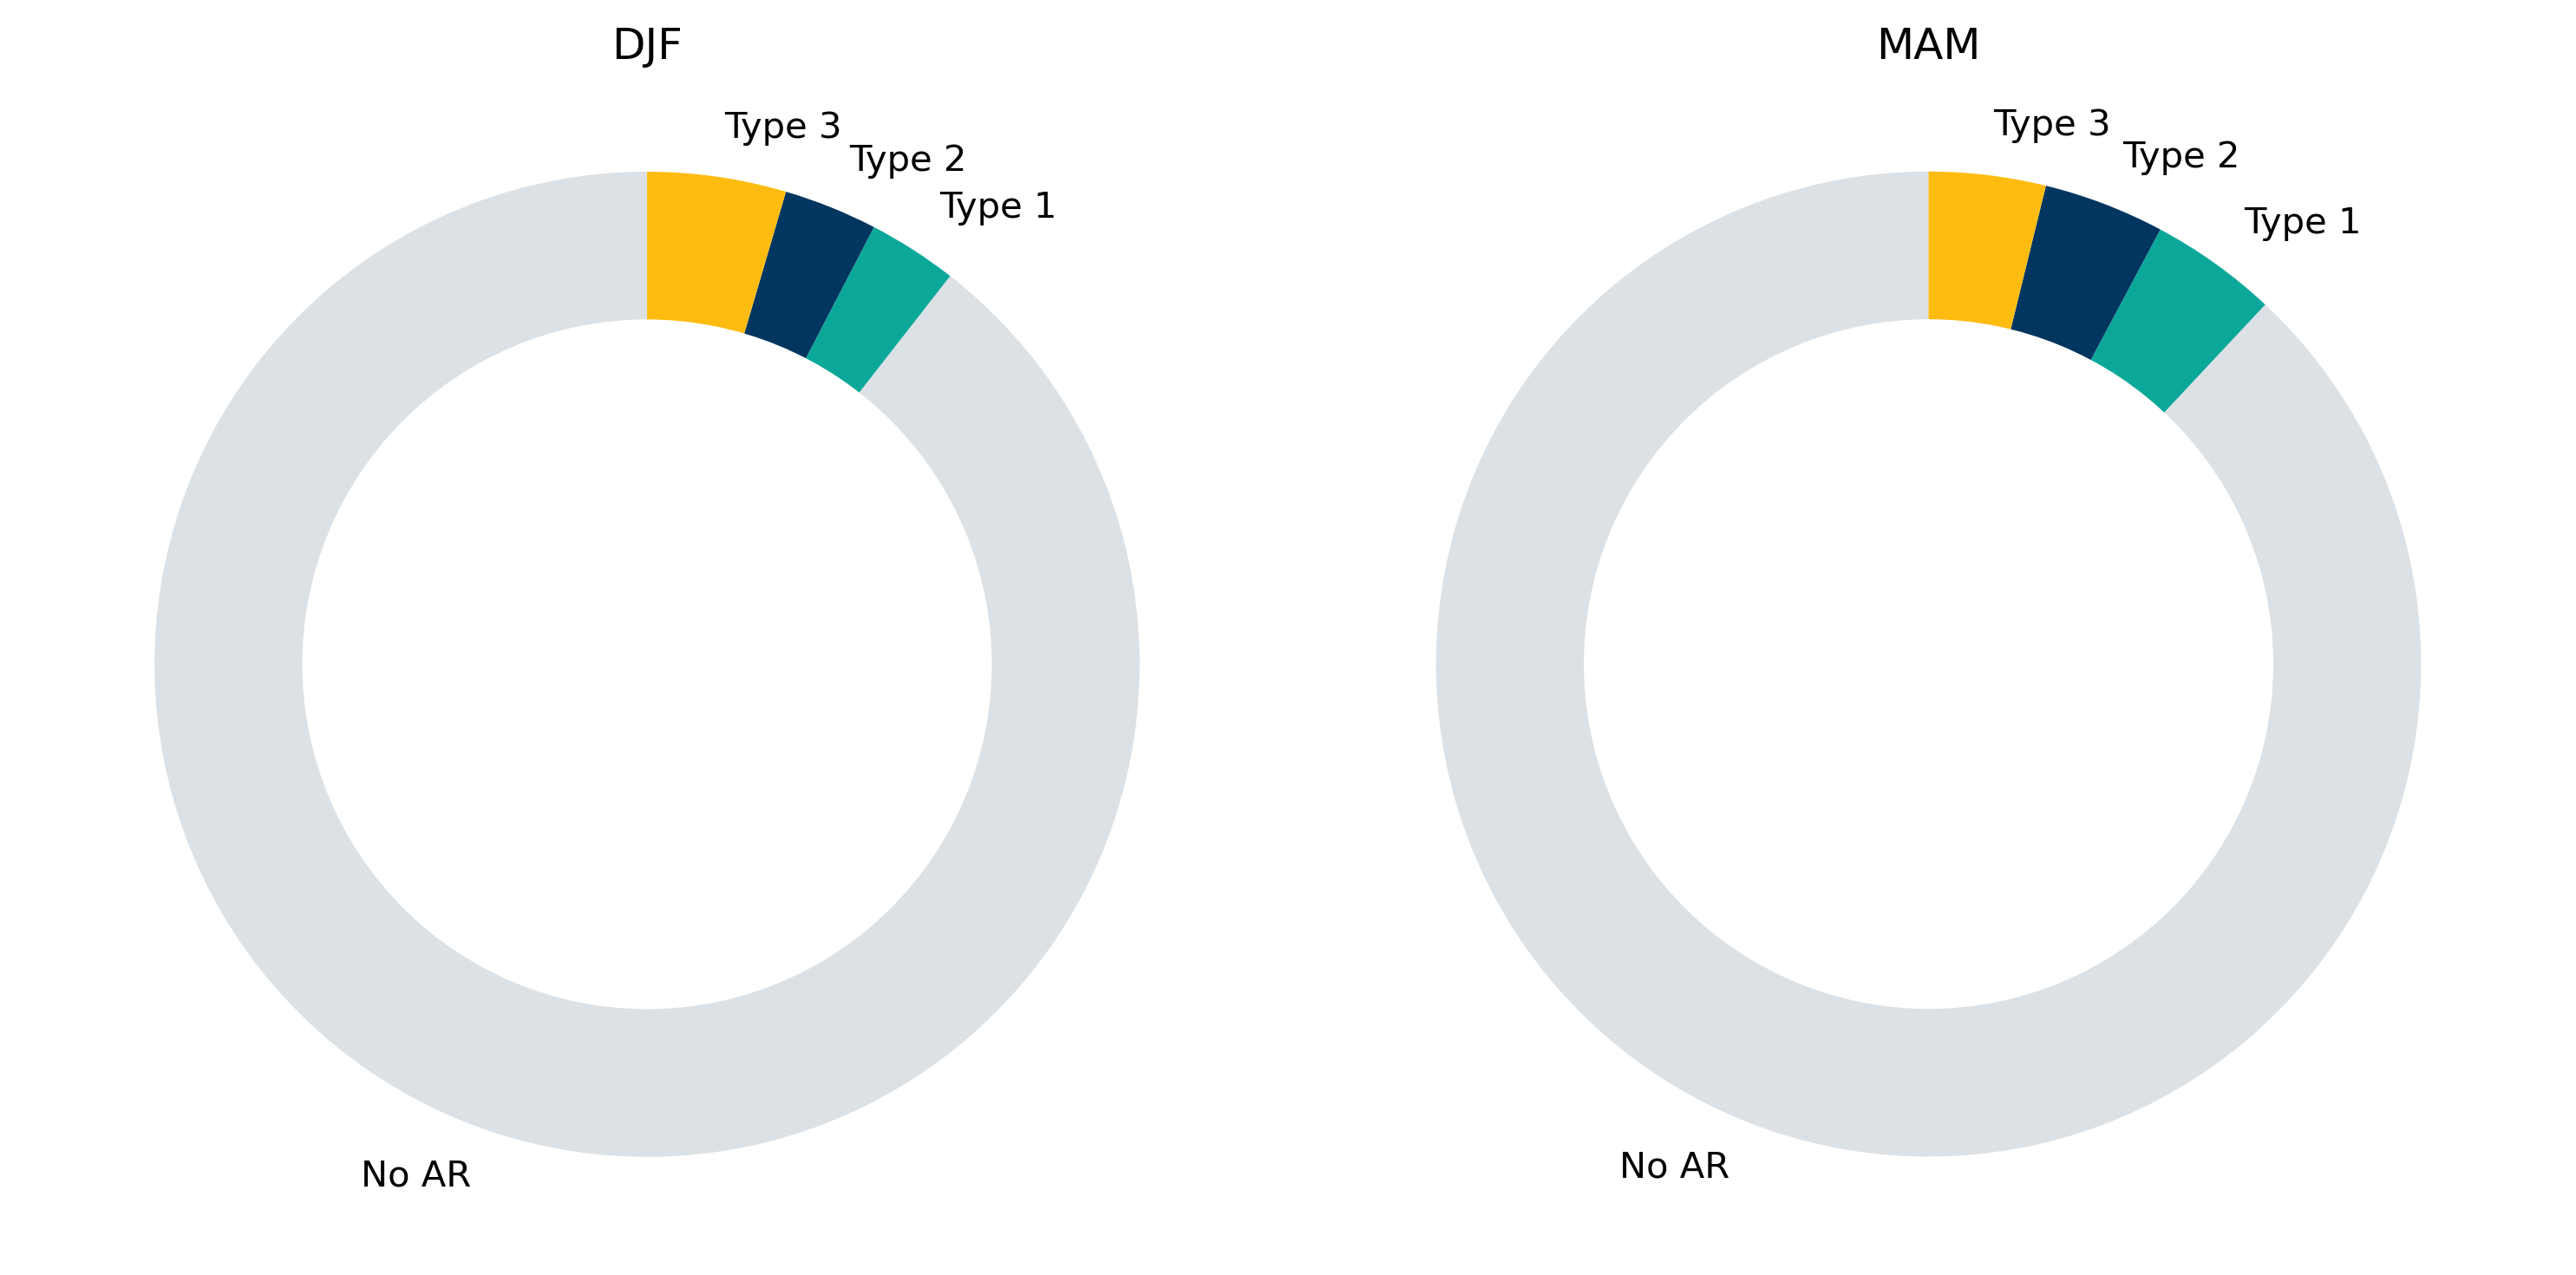

In [7]:
fname = path_to_figs + 'donut_plot'
fmt = 'png'

# Pie chart
labels = ['No AR', 'Type 1', 'Type 2', 'Type 3']
plt_labels = ['DJF', 'MAM']
djf_sizes = [89.46, 2.93, 3.07, 4.55]
mam_sizes = [88.02, 4.18, 3.97, 3.83]
sizes = [djf_sizes, mam_sizes]
#colors
colors = ['#DCE1E5','#0BA89A','#003660', '#FEBC11']
 
fig = plt.figure()
fig.set_size_inches((10.0,5.0))
fig.dpi = 300
nrows = 1
ncols = 2
nplots = nrows*ncols
for i in np.arange(nplots):
    ax = plt.subplot(nrows, ncols, i+1)
    ax.pie(sizes[i], colors = colors, labels=labels, autopct=None, startangle=90)
    #draw circle
    centre_circle = plt.Circle((0,0),0.70,fc='white')
    ax.add_artist(centre_circle)
    # Equal aspect ratio ensures that pie is drawn as a circle
    ax.axis('equal')  
    plt.title(plt_labels[i])

plt.tight_layout()
# plt.show()

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=300)

plotFile = fname + '.png'
print(plotFile)
# display(Image(plotFile))

In [8]:
# combine ar annual df with ao annual df
print(len(df_djf), len(df_mam), len(df_index_djf), len(df_index_mam))

39 40 39 40


In [9]:
# join indices with AR count
new_djf = df_djf.join(df_index_djf)
new_mam = df_mam.join(df_index_mam)

In [10]:
## TO DO: ADD el nino mean, la nina mean, neutral mean, 5-year running mean

fname = path_to_figs + 'ENSO_barplot_' + ssn
fmt = 'png'
fig = plt.figure()
fig.set_size_inches((8.5,11.0))
fig.dpi = 300
nplots=4

artype = ['AR_CAT1', 'AR_CAT2', 'AR_CAT3', 'total']
ssn_label = ['AR Type 1', 'AR Type 2', 'AR Type 3', 'All Types']
flatui = ['grey', 'red', 'c']

for i in np.arange(nplots):
    ax = fig.add_subplot(4, 1, i+1)
    data = df2_ssn
    sns.barplot(x=data.index.year, y=data[artype[i]], hue=data['ENSO_CAT'],
                data=data, palette=flatui, dodge=False)
    sns.set_style("ticks")
    ax.set_ylabel('# of AR Days', fontsize=12)
    ax.set_xlabel('')

    # Format the x axis
    ax.xaxis.set_major_locator(mticker.MultipleLocator(5))
#     ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.set_xticklabels(np.arange(1975, 2020, 5), fontsize=12)
    ax.legend(loc='upper center')
    plt.gca().legend().set_title('')
    plt.ylim(0, 30)
    ax.set_title(ssn_label[i], loc='left')
    
plt.tight_layout()
# Save the figure
fig.savefig('%s.%s' % (fname, fmt), bbox_inches='tight', dpi=fig.dpi)
fig.clf()

plotFile = fname + '.png'
print(plotFile)
display(Image(plotFile))

NameError: name 'ssn' is not defined

In [11]:
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    pval = dfcols.transpose().join(dfcols, how='outer')
    tval = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 4)
            tval[r][c], pval[r][c] = pearsonr_autocorrelation(df[r], df[c], alpha=0.05, autocorr=True)
    return pvalues, pval

In [12]:
## correlations between indices and AR frequency
corrMatrix = new_djf.corr()
corrMatrix

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,ao,pdo,enso,sh
AR_CAT1,1.00,-0.06,-0.11,0.33,-0.27,0.12,0.19,0.03
AR_CAT2,-0.06,1.00,0.41,0.69,0.32,-0.17,0.11,-0.00
AR_CAT3,-0.11,0.41,1.00,0.82,0.30,0.01,0.31,-0.22
AR_ALL,0.33,0.69,0.82,1.00,0.23,-0.01,0.34,-0.14
ao,-0.27,0.32,0.30,0.23,1.00,-0.32,-0.16,-0.26
pdo,0.12,-0.17,0.01,-0.01,-0.32,1.00,0.44,-0.02
enso,0.19,0.11,0.31,0.34,-0.16,0.44,1.00,-0.24
sh,0.03,-0.00,-0.22,-0.14,-0.26,-0.02,-0.24,1.00


In [13]:
# calculate two-tailed pvalues with F test
pval, pval2 = calculate_pvalues(new_djf)
pval2

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,ao,pdo,enso,sh
AR_CAT1,NaN,0.66,0.51,0.11,0.03,0.48,0.13,0.82
AR_CAT2,0.66,NaN,0.03,0.00,0.06,0.46,0.57,1.00
AR_CAT3,0.51,0.03,NaN,0.00,0.10,0.96,0.11,0.33
AR_ALL,0.11,0.00,0.00,NaN,0.26,0.96,0.13,0.59
ao,0.03,0.06,0.10,0.26,NaN,0.09,0.32,0.18
pdo,0.48,0.46,0.96,0.96,0.09,NaN,0.01,0.91
enso,0.13,0.57,0.11,0.13,0.32,0.01,NaN,0.17
sh,0.82,1.00,0.33,0.59,0.18,0.91,0.17,NaN


In [14]:
## correlations between indices and AR frequency
corrMatrix = new_mam.corr()
corrMatrix

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,ao,pdo,enso,sh
AR_CAT1,1.00,0.22,-0.14,0.61,-0.23,0.32,-0.03,-0.05
AR_CAT2,0.22,1.00,-0.04,0.65,0.13,0.14,0.15,-0.12
AR_CAT3,-0.14,-0.04,1.00,0.49,0.18,0.28,0.47,-0.27
AR_ALL,0.61,0.65,0.49,1.00,0.05,0.43,0.35,-0.26
ao,-0.23,0.13,0.18,0.05,1.00,-0.28,0.13,-0.27
pdo,0.32,0.14,0.28,0.43,-0.28,1.00,0.44,0.00
enso,-0.03,0.15,0.47,0.35,0.13,0.44,1.00,-0.40
sh,-0.05,-0.12,-0.27,-0.26,-0.27,0.00,-0.40,1.00


In [15]:
# calculate two-tailed pvalues with F test
pval, pval2 = calculate_pvalues(new_djf)
pval2

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,ao,pdo,enso,sh
AR_CAT1,NaN,0.66,0.51,0.11,0.03,0.48,0.13,0.82
AR_CAT2,0.66,NaN,0.03,0.00,0.06,0.46,0.57,1.00
AR_CAT3,0.51,0.03,NaN,0.00,0.10,0.96,0.11,0.33
AR_ALL,0.11,0.00,0.00,NaN,0.26,0.96,0.13,0.59
ao,0.03,0.06,0.10,0.26,NaN,0.09,0.32,0.18
pdo,0.48,0.46,0.96,0.96,0.09,NaN,0.01,0.91
enso,0.13,0.57,0.11,0.13,0.32,0.01,NaN,0.17
sh,0.82,1.00,0.33,0.59,0.18,0.91,0.17,NaN


In [16]:
## 5 year rolling mean
data_roll_djf = new_djf.rolling(5).mean()

## correlations between indices and AR frequency
corrMatrix = data_roll_djf.corr()
corrMatrix

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,ao,pdo,enso,sh
AR_CAT1,1.00,0.31,0.20,0.52,0.21,-0.35,0.23,-0.23
AR_CAT2,0.31,1.00,0.55,0.81,0.53,-0.40,0.38,-0.37
AR_CAT3,0.20,0.55,1.00,0.89,0.71,-0.07,0.46,-0.64
AR_ALL,0.52,0.81,0.89,1.00,0.70,-0.29,0.49,-0.60
ao,0.21,0.53,0.71,0.70,1.00,-0.10,0.43,-0.75
pdo,-0.35,-0.40,-0.07,-0.29,-0.10,1.00,0.46,0.01
enso,0.23,0.38,0.46,0.49,0.43,0.46,1.00,-0.36
sh,-0.23,-0.37,-0.64,-0.60,-0.75,0.01,-0.36,1.00


In [17]:
# calculate two-tailed pvalues with F test
pval, pval2 = calculate_pvalues(data_roll_djf)
pval2

../modules/statistical_tests.py:143: RuntimeWarning: invalid value encountered in sqrt
  s_T = np.sqrt((1-r**2)/df)


,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,ao,pdo,enso,sh
AR_CAT1,NaN,0.62,0.85,0.91,0.66,0.88,0.76,0.75
AR_CAT2,0.62,NaN,0.77,0.74,0.60,0.98,0.78,NaN
AR_CAT3,0.85,0.77,NaN,0.89,0.60,0.98,0.80,0.99
AR_ALL,0.91,0.74,0.89,NaN,0.81,NaN,1.00,NaN
ao,0.66,0.60,0.60,0.81,NaN,0.92,0.21,0.63
pdo,0.88,0.98,0.98,NaN,0.92,NaN,0.77,1.00
enso,0.76,0.78,0.80,1.00,0.21,0.77,NaN,0.64
sh,0.75,NaN,0.99,NaN,0.63,1.00,0.64,NaN


In [18]:
## 5 year rolling mean
data_roll_mam = new_mam.rolling(5).mean()

## correlations between indices and AR frequency
corrMatrix = data_roll_mam.corr()
corrMatrix

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,ao,pdo,enso,sh
AR_CAT1,1.00,0.50,0.08,0.79,0.07,0.48,0.46,-0.58
AR_CAT2,0.50,1.00,0.14,0.76,0.38,0.16,0.25,-0.43
AR_CAT3,0.08,0.14,1.00,0.55,-0.08,0.23,0.37,-0.25
AR_ALL,0.79,0.76,0.55,1.00,0.17,0.43,0.52,-0.61
ao,0.07,0.38,-0.08,0.17,1.00,-0.38,0.03,-0.20
pdo,0.48,0.16,0.23,0.43,-0.38,1.00,0.64,-0.15
enso,0.46,0.25,0.37,0.52,0.03,0.64,1.00,-0.42
sh,-0.58,-0.43,-0.25,-0.61,-0.20,-0.15,-0.42,1.00


In [19]:
# calculate two-tailed pvalues with F test
pval, pval2 = calculate_pvalues(data_roll_mam)
pval2

,AR_CAT1,AR_CAT2,AR_CAT3,AR_ALL,ao,pdo,enso,sh
AR_CAT1,NaN,0.35,0.88,0.28,0.91,0.44,0.44,0.65
AR_CAT2,0.35,NaN,0.78,0.43,0.51,0.80,0.69,0.59
AR_CAT3,0.88,0.78,NaN,0.52,0.90,0.76,0.55,0.72
AR_ALL,0.28,0.43,0.52,NaN,0.89,0.73,0.66,0.75
ao,0.91,0.51,0.90,0.89,NaN,0.78,0.97,0.75
pdo,0.44,0.80,0.76,0.73,0.78,NaN,0.49,0.96
enso,0.44,0.69,0.55,0.66,0.97,0.49,NaN,0.61
sh,0.65,0.59,0.72,0.75,0.75,0.96,0.61,NaN


/home/sbarc/students/nash/anaconda3/envs/ar_types/lib/python3.7/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/home/sbarc/students/nash/anaconda3/envs/ar_types/lib/python3.7/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


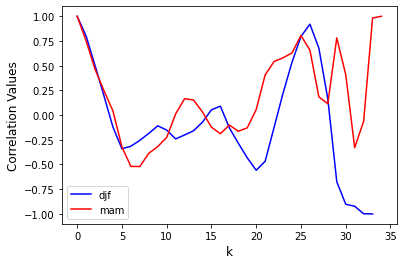

In [20]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.autocorr.html
# calculate p-value based on autocorrelation
auto_corr_djf = []
auto_corr_mam = []
for i in np.arange(50):
    auto_corr_djf.append(data_roll_djf.ao.autocorr(lag=i))
    auto_corr_mam.append(data_roll_mam.ao.autocorr(lag=i))

plt.plot(np.arange(50), auto_corr_djf, 'b', label='djf')
plt.plot(np.arange(50), auto_corr_mam, 'r', label='mam')
plt.ylabel('Correlation Values', fontsize=12)
plt.xlabel('k', fontsize=12)
plt.legend()
plt.show()

In [21]:
# lag-1 correlations for all ts
var_lst = ['AR_ALL', 'ao', 'pdo', 'enso', 'sh']
auto_corr_djf = []
auto_corr_mam = []
for i, vr in enumerate(var_lst):
    auto_corr_djf.append(new_djf[vr].autocorr(lag=1))
    auto_corr_mam.append(new_mam[vr].autocorr(lag=1))

In [22]:
var_lst = ['AR_ALL', 'ao', 'pdo', 'enso', 'sh']
print(auto_corr_djf, auto_corr_mam)

[0.30817733043322976, 0.14312483190195924, 0.3239830542137262, -0.023370172599398487, -0.01289896128545756] [0.10592085594826738, 0.006638105633323437, 0.4057542234355101, 0.21769707897364898, -0.01692741255601124]


In [23]:
# lag-1 correlations for all ts
var_lst = ['AR_ALL', 'ao', 'pdo', 'enso', 'sh']
auto_corr_djf = []
auto_corr_mam = []
for i, vr in enumerate(var_lst):
    auto_corr_djf.append(data_roll_djf[vr].autocorr(lag=1))
    auto_corr_mam.append(data_roll_mam[vr].autocorr(lag=1))
    print(vr, data_roll_djf[vr].autocorr(lag=1), data_roll_mam[vr].autocorr(lag=1))

AR_ALL 0.8925285272492214 0.8566851536328683
ao 0.7995050432848553 0.7504464131949842
pdo 0.8907857319401653 0.8722216736608098
enso 0.6630394880575643 0.8107423493132617
sh 0.8146193208472157 0.7836755842082618


/home/nash/DATA/repositories/AR_types/figs/artype_ao_5yrmean_.png


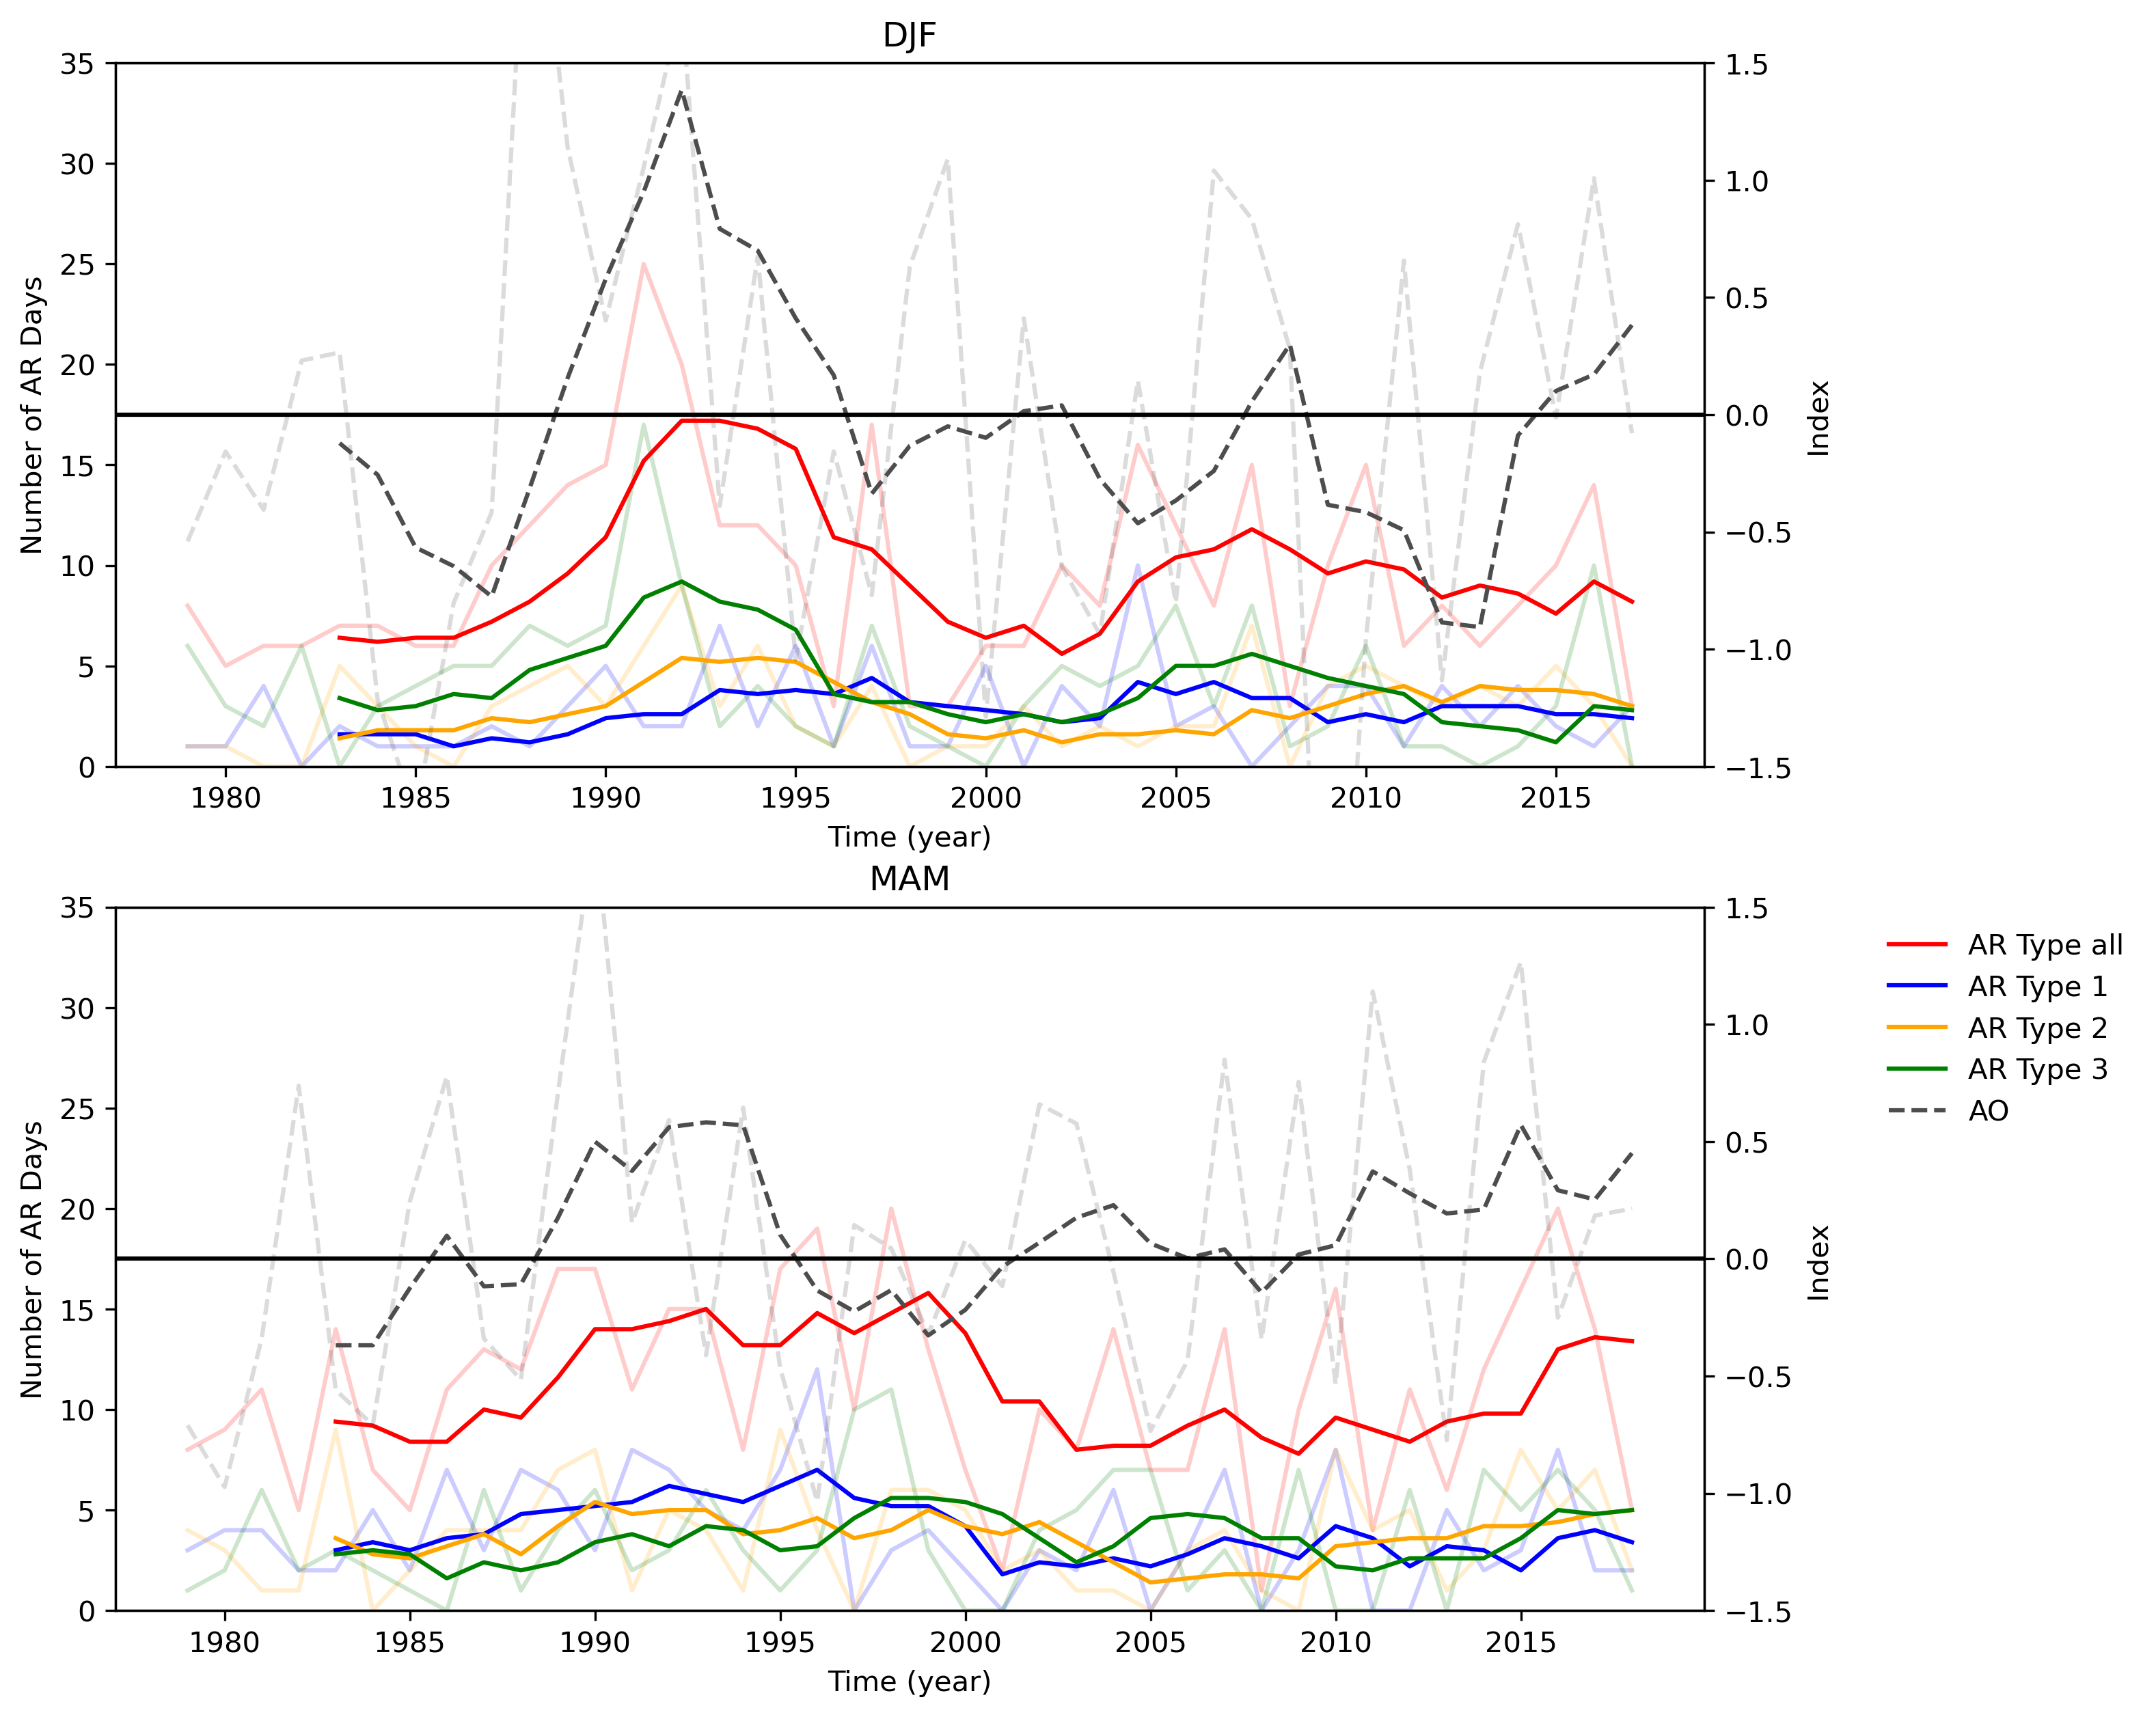

<Figure size 3000x3000 with 0 Axes>

In [27]:
# set up plot
data_lst = [data_roll_djf, data_roll_mam]
data_lst2 = [new_djf, new_mam]
plt_labels = ['DJF', 'MAM']

# set up figure
outfile = path_to_figs + 'artype_ao_5yrmean_' + '.png'
fig = plt.figure()
fig.set_size_inches((10.0,10.0))
fig.dpi = 300
nrows = 2
ncols = 1
nplots = nrows*ncols

alph = 0.2

for i in np.arange(nplots):
    ax = plt.subplot(nrows, ncols, i+1)
    data = data_lst2[i]
    time = data.index.year
    # lines on left axis
    lns12 = ax.plot(time, data.AR_ALL, color='red', label='AR Type all', alpha=alph)
    lns22 = ax.plot(time, data.AR_CAT1, color="blue", label='AR Type 1', alpha=alph)
    lns32 = ax.plot(time, data.AR_CAT2, color="orange", label='AR Type 2', alpha=alph)
    lns42 = ax.plot(time, data.AR_CAT3, color="green", label='AR Type 3', alpha=alph)
    # lines on right axis
    ax2 = ax.twinx()
    lns52 = ax2.plot(time, data.ao, color=(0.6/2.0, 0.6/2.0, 0.6/2.0), linestyle='--', label='AO', alpha=alph)
    
    # lines on left axis
    data = data_lst[i]
    time = data.index.year
    lns1 = ax.plot(time, data.AR_ALL, color='red', label='AR Type all')
    lns2 = ax.plot(time, data.AR_CAT1, color="blue", label='AR Type 1')
    lns3 = ax.plot(time, data.AR_CAT2, color="orange", label='AR Type 2')
    lns4 = ax.plot(time, data.AR_CAT3, color="green", label='AR Type 3')
    ax.grid(False)
    # lines on right axis
    lns5 = ax2.plot(time, data.ao, color=(0.6/2.0, 0.6/2.0, 0.6/2.0), linestyle='--', label='AO')
#     lns6 = ax2.plot(time, data.sh, color=(0.8/2.0, 0.8/2.0, 0.8/2.0), linestyle=':', label='SH')
#     lns7 = ax2.plot(time, data.pdo, color=(1./2.0, 1./2.0, 1./2.0), linestyle='-.', label='PDO')
#     lns8 = ax2.plot(time, data.enso, color=(1.2/2.0, 1.2/2.0, 1.2/2.0), linestyle='-', label='ENSO')
    ax2.axhline(0, color='k')

    # labels
    ax.set_xlabel("Time (year)")
    ax.set_ylabel(r"Number of AR Days")
    ax2.set_ylabel(r"Index")
    ax2.set_ylim(-1.5, 1.5)
    ax.set_ylim(0,35)
    plt.title(plt_labels[i])
    
# legend for all lines
lns = lns1+lns2+lns3+lns4+lns5
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, frameon=False, ncol=1, bbox_to_anchor=(1.1, 1), loc='upper left')

# Save the figure
fig.savefig(outfile, bbox_inches='tight', dpi=fig.dpi)
fig.clf()

print(outfile)
display(Image(outfile))